In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms    # データの前処理で使う
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## データの準備

In [2]:
# データの前処理の定義
transform = transforms.Compose([
    transforms.ToTensor(),  # Tensorに変換
    transforms.Normalize((0.1307,), (0.3081))   # 平均:0.1307, 標準偏差:0.3081になるよう正規化
])

# データのダウンロード
train_dataset = torchvision.datasets.MNIST(
    root='./data',      # データの保存先
    train=True,         # 学習用
    download=True,      # ダウンロードする
    transform=transform)    # データの前処理

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,        # 評価用
    download=True,
    transform=transform)

# データローダーの作成（ミニバッチの作成）
train_loader = torch.utils.data.DataLoader(
    train_dataset,  # 使うデータセット
    batch_size=64,  # バッチサイズ
    shuffle=True)   # シャッフルする

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:02<00:00, 3313801.14it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 488208.24it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1112890.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 9071680.37it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## モデルの定義

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()         # データを1列にする関数
        self.fc1 = nn.Linear(28*28, 128)    # 入力:28*28、出力:128
        self.sigmoid = nn.Sigmoid()         # 活性化関数:Sigmoid
        self.fc2 = nn.Linear(128, 10)       # 入力:128、出力:10

    def forward(self, x):
        x = self.flatten(x)     # データを1列にする
        x = self.fc1(x)         # 入力層->中間層
        x = self.sigmoid(x)     # 活性化関数
        x = self.fc2(x)         # 中間層->出力層
        return x

# 再現性のためにシードを固定
torch.manual_seed(42)
np.random.seed(42)

model = MLP()   # モデルの生成
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## 損失関数と最適化アルゴリズム

In [5]:
criterion = nn.CrossEntropyLoss()   # 損失関数:交差エントロピー損失
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 最適化アルゴリズム:確率的勾配降下法

## モデルの学習

In [7]:
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()   # モデルを学習モードにする
    losses = []     # 誤差を記録するリスト
    # === エポックのループ ===
    for epoch in range(epochs):
        running_loss = 0.0
        # === ミニバッチのループ(64枚×938回) ===
        for i, data in enumerate(train_loader):
            inputs, labels = data               # 画像とラベル(正解データ)に分ける
            optimizer.zero_grad()               # 勾配の初期化
            outputs = model(inputs)             # 予測する
            loss = criterion(outputs, labels)   # 損失の計算
            loss.backward()                     # 勾配の計算
            optimizer.step()                    # パラメータの更新

            running_loss += loss.item()         # ミニバッチごとの誤差を足す
        epoch_loss = running_loss / len(train_loader)   # 1エポックの誤差
        losses.append(epoch_loss)               # 1エポックの誤差を記録
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
    return losses

# 学習の実行
epochs = 10
losses = train(model, train_loader, criterion, optimizer, epochs)

Epoch 1/10, Loss: 1.3908
Epoch 2/10, Loss: 0.6393
Epoch 3/10, Loss: 0.4719
Epoch 4/10, Loss: 0.4032
Epoch 5/10, Loss: 0.3650
Epoch 6/10, Loss: 0.3401
Epoch 7/10, Loss: 0.3218
Epoch 8/10, Loss: 0.3075
Epoch 9/10, Loss: 0.2957
Epoch 10/10, Loss: 0.2854


## 誤差の推移グラフ

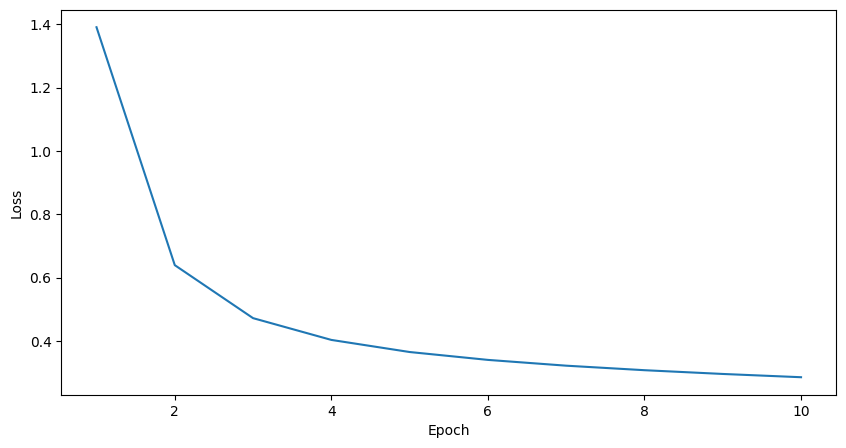

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## モデルの評価（正解率）

In [10]:
def test(model, test_loader):
    model.eval()    # モデルを評価モードにする
    correct = 0     # 正解数をカウントする変数
    total = 0
    with torch.no_grad():   # 勾配計算なし
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)     # 10個の中で一番良いやつを1つ抽出する
            total += labels.size(0)
            correct += (predicted == labels).sum().item()   # 予測と正解が一致している個数

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')

test(model, test_loader)


Accuracy: 92.29%


## 予測結果の可視化

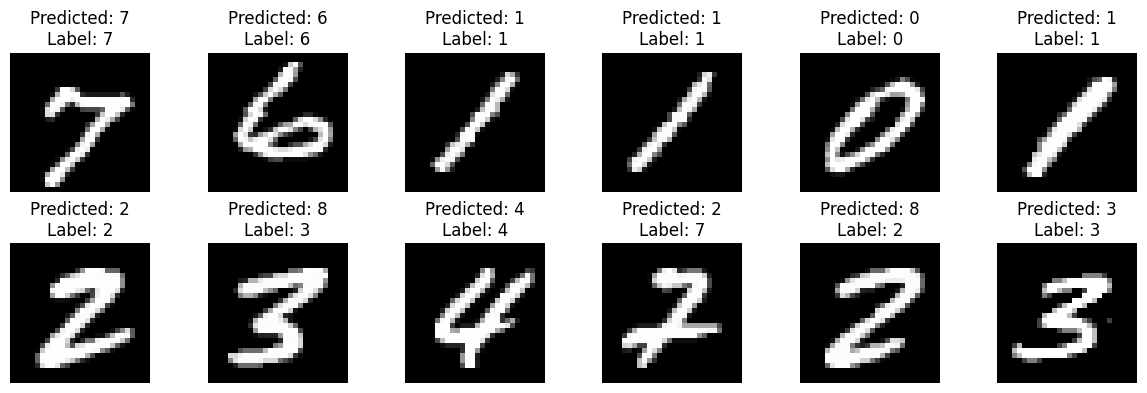

In [14]:
def visualize_predictions(model, test_loader):
    model.eval()    # モデルを評価モードにする
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

    fig = plt.figure(figsize=(12, 4))
    for i in range(12):
        ax = fig.add_subplot(2, 6, i+1)
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'Predicted: {predicted[i].item()}\nLabel: {labels[i].item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader)

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

def evaluate_model(model, test_loader, device="cpu"):
    model.eval()    # モデルを評価モードにする
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 混合行列の計算
    cm = confusion_matrix(all_labels, all_predictions)
    # Precision, Recall, F1スコアの計算
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels,
        all_predictions,
        average='weighted')
    # Accuracyの計算
    accuracy = accuracy_score(all_labels, all_predictions)

    return cm, precision, recall, f1_score, accuracy

# モデルの評価
cm, precision, recall, f1_score, accuracy = evaluate_model(model, test_loader)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

Accuracy: 0.9229
Precision: 0.9228
Recall: 0.9229
F1 Score: 0.9227


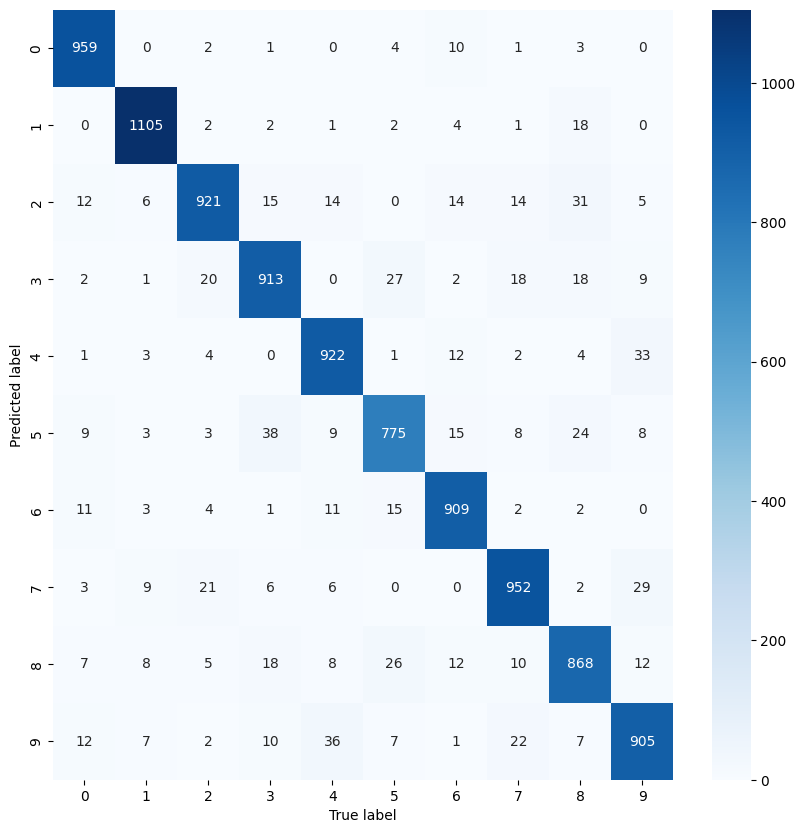

In [12]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()